# Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).
**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


 **Данные** 

[final_steel.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f3fbea3a-263d-4e1c-babd-0bf07920c911/final_steel.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_steel/`.

# План решения задачи
1. Подгружаем библиотеки и модули.
2. Подгружаем таблицы, исправляем типы данных.
3. Определяем номера партий, у которых есть замеры по температуре.
4. Объединяем таблицы со всеми данными для модели. Заполняем пропуски. Проверяем на аномалии и дубликаты.
5. Выделеним целевой признак. Разобьем на валидационную/тестовую выборки. Разбьем на признаки/целевой признак. Оценим важность признаков.
6. Выбор моделей. Обучение модели, подбор гиперпараметров. Оценить качество с кросс-валидацией.
7. Оценка эффективности моделей на тестовой выборке.
8. Вывод по проекту.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy import stats as stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor # ?

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import time

warnings.filterwarnings('ignore')


# Анализ данных

### Данные об электродах

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.tail(20)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14856,3238,2019-08-31 23:32:03,2019-08-31 23:36:28,1.017459,0.850749
14857,3238,2019-08-31 23:38:38,2019-08-31 23:41:28,0.717559,0.520623
14858,3239,2019-09-01 01:26:53,2019-09-01 01:29:20,0.512136,0.403724
14859,3239,2019-09-01 01:32:52,2019-09-01 01:35:44,0.665472,0.458612
14860,3239,2019-09-01 01:38:57,2019-09-01 01:42:00,0.716788,0.478426
14861,3239,2019-09-01 01:43:37,2019-09-01 01:45:48,0.486958,0.315940
14862,3239,2019-09-01 01:52:51,2019-09-01 01:57:45,1.156764,0.725063
14863,3239,2019-09-01 02:07:01,2019-09-01 02:07:54,0.205792,0.135075
14864,3239,2019-09-01 02:09:28,2019-09-01 02:11:19,0.434492,0.277050
14865,3239,2019-09-01 02:13:38,2019-09-01 02:15:43,0.488352,0.317727


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


- видим, что есть аномалия в значении реактивная мощность -715

In [6]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

In [7]:
data_arc[data_arc['key']==44]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
190,44,2019-05-04 22:09:23,2019-05-04 22:11:49,0.514491,0.406311
191,44,2019-05-04 22:14:17,2019-05-04 22:17:39,0.691813,0.554531
192,44,2019-05-04 22:19:54,2019-05-04 22:24:09,0.927365,0.654955
193,44,2019-05-04 22:30:57,2019-05-04 22:31:39,0.155866,0.112500
194,44,2019-05-04 22:32:45,2019-05-04 22:34:57,0.501012,0.339709
195,44,2019-05-04 22:44:58,2019-05-04 22:46:04,0.253021,0.163590
196,44,2019-05-04 22:47:31,2019-05-04 22:49:34,0.489501,0.352497
197,44,2019-05-05 00:32:02,2019-05-05 00:34:36,0.537892,0.426978
198,44,2019-05-05 00:36:13,2019-05-05 00:46:45,2.343373,1.921817
199,44,2019-05-05 00:49:21,2019-05-05 00:52:55,0.832662,0.637833


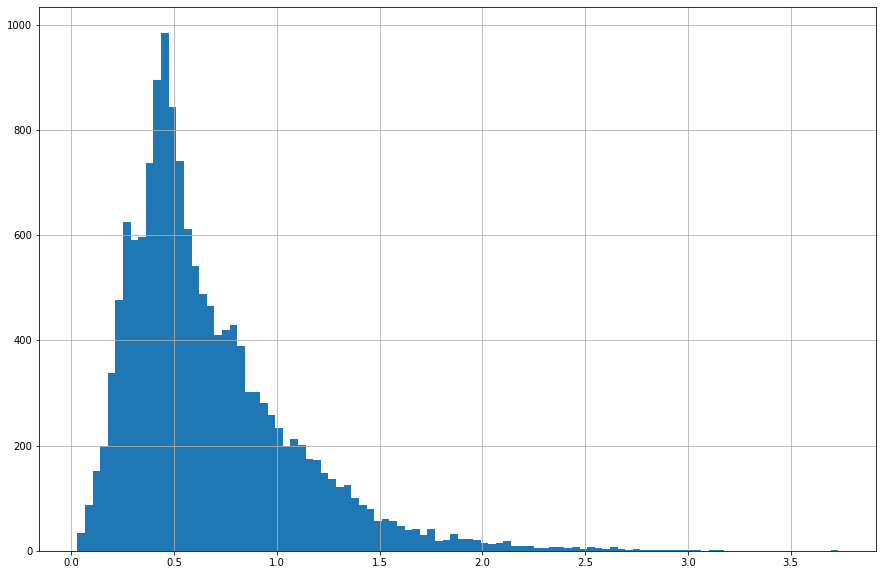

In [8]:
data_arc['Активная мощность'].hist(bins=100, figsize=(15,10))

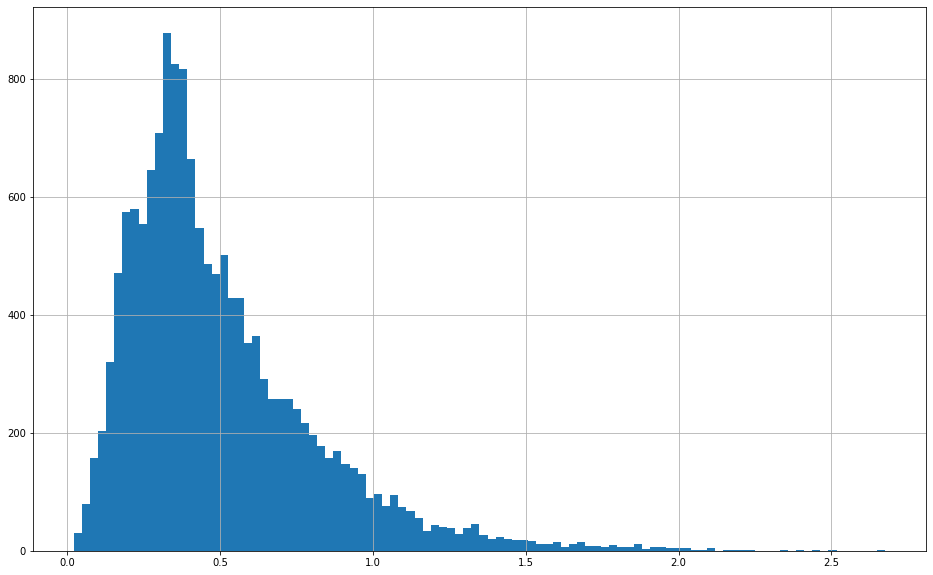

In [9]:
# Построим гистограмму реактивной мощности отрезав отрицатк=ельные значения
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(16,10)) 

### Данные о подаче сыпучих материалов (объём)

In [10]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [12]:
data_bulk['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

In [13]:
data_bulk[data_bulk['key']==44]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
41,44,NaN,NaN,NaN,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,159.0,154.0,321.0,159.0


- все значения уникальные

In [14]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dcedc5c90>,
      dtype=object)

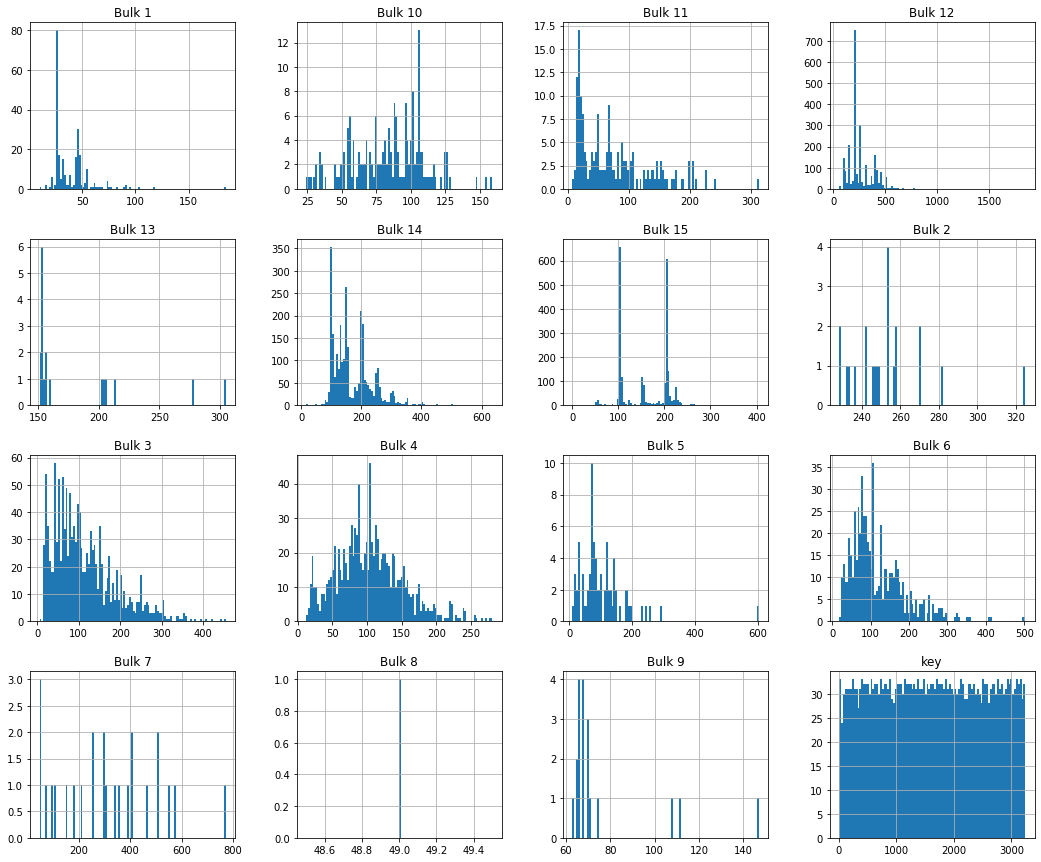

In [15]:
data_bulk.hist(bins=100, figsize=(18,15))

### Данные о подаче сыпучих материалов (время)

In [16]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [17]:
data_bulk_time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


In [18]:
data_bulk_time['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

In [19]:
data_bulk_time[data_bulk_time['key']==44]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
41,44,NaN,NaN,NaN,NaN,NaN,2019-05-04 22:33:48,NaN,NaN,NaN,NaN,NaN,2019-05-05 00:39:35,2019-05-05 00:39:35,2019-05-04 22:15:42,2019-05-05 00:39:35


- все значения уникальные

In [20]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


### Данные о продувке сплава газом

In [21]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
data_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [23]:
data_gas['key'].value_counts()

2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

In [24]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


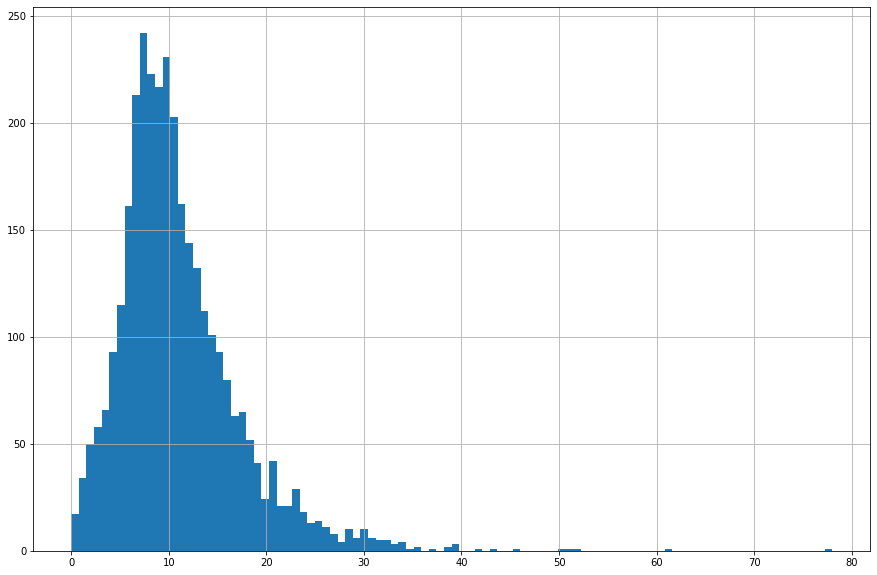

In [25]:
data_gas['Газ 1'].hist(bins=100, figsize=(15,10))

### Результаты измерения температуры

In [26]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [27]:
data_temp.tail(20)

,key,Время замера,Температура
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN


In [28]:
print(data_temp[data_temp['key']==44])

     key         Время замера  Температура
225   44  2019-05-04 22:13:44       1600.0
226   44  2019-05-04 22:32:26       1608.0
227   44  2019-05-04 22:39:37       1619.0
228   44  2019-05-04 22:43:49       1600.0
229   44  2019-05-04 22:44:29       1605.0
230   44  2019-05-04 22:46:49       1601.0
231   44  2019-05-04 22:47:20       1601.0
232   44  2019-05-04 22:50:26       1607.0
233   44  2019-05-05 00:35:31       1570.0
234   44  2019-05-05 00:48:32       1599.0
235   44  2019-05-05 01:01:00       1610.0
236   44  2019-05-05 01:07:12       1608.0
237   44  2019-05-05 01:09:04       1602.0
238   44  2019-05-05 01:09:46       1602.0
239   44  2019-05-05 01:12:22       1602.0
240   44  2019-05-05 01:13:17       1603.0


In [29]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

In [30]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


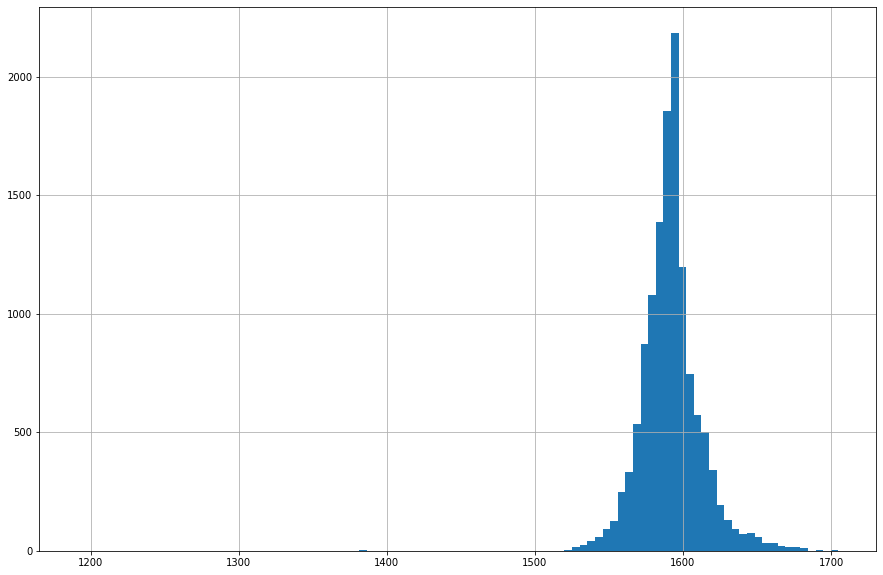

In [31]:
data_temp['Температура'].hist(bins=100, figsize=(15,10))

### Данные о проволочных материалах (объём)

In [32]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
data_wire.tail(20)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3061,3222,25.072321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3062,3223,124.094887,21.202478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3063,3224,96.096001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3064,3225,83.123040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3065,3226,63.335999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3066,3227,186.076798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067,3228,20.092800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3068,3229,86.180641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3069,3230,76.046875,30.190161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,3231,125.667358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_wire['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

In [35]:
data_wire[data_wire['key']==44]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
41,44,69.189123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dc4e08190>,
      dtype=object)

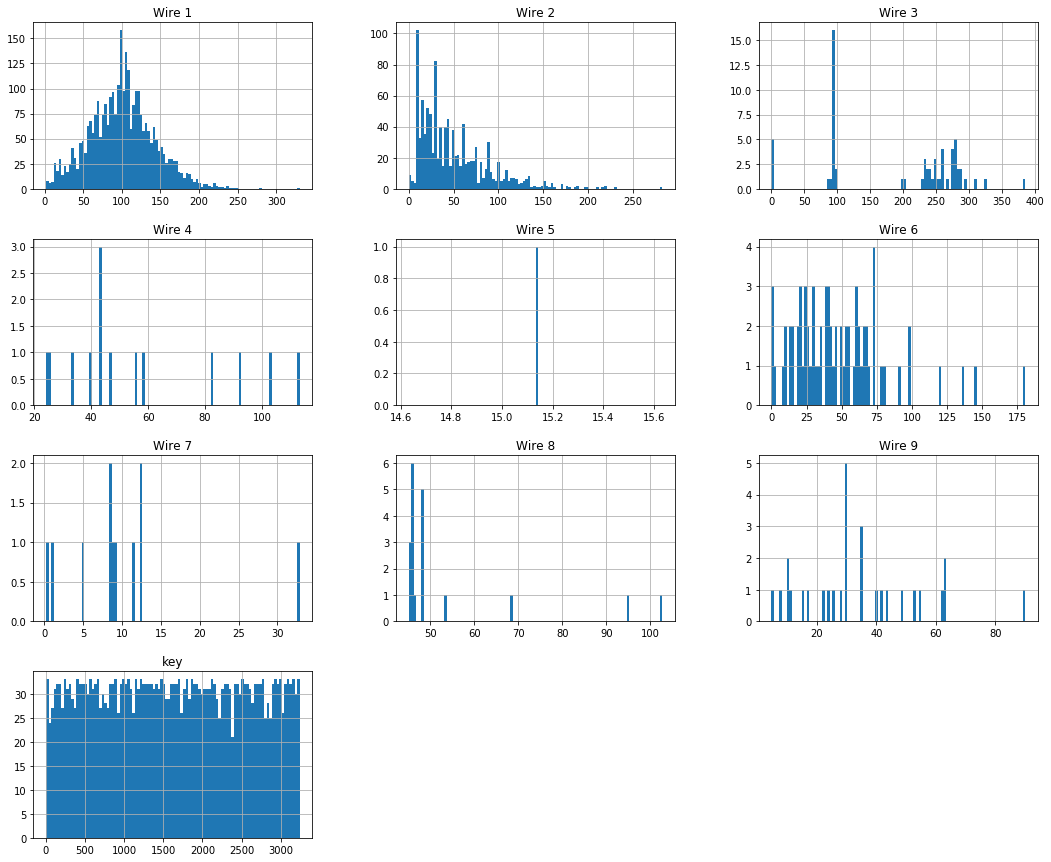

In [37]:
data_wire.hist(bins=100, figsize=(18,15))

### Данные о проволочных материалах (время)

In [38]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [39]:
data_wire_time.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire_time['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

In [41]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Данные загружены и изучены: 
 - `data_arc` есть аномальное значение (реактивная мощность = -715.504924).  В номерах партий есть пропуски.
 - `data_bulk` и `data_bulk_time` есть пропуски. Разные примеси и разное их кол-во добавляется в разные партии в разное время. В номерах партий есть пропуски.
 - `data_wire` и `data_wire_time` есть пропуски. Разное кол-во и разные типы проволоки  добавляется в разное время из разных емкостей.
 - `data_temp` есть пропуски в столбце с показаниями температуры.

# 2. Подготовка данных

## 2.1 Подготовка data_arc

In [42]:
# Переименуем названия столбцов из кириллицы в латиницу
data_arc.columns = ['key','start','finish','active_power','reactive_power']
# Возмем только положительные значения реактивной мощности
data_arc = data_arc.query('reactive_power > 0')
# Столбцы start и finish переведем из object в datetime
data_arc['start'] = pd.to_datetime(data_arc['start'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish'] = pd.to_datetime(data_arc['finish'], format='%Y-%m-%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
key               14875 non-null int64
start             14875 non-null datetime64[ns]
finish            14875 non-null datetime64[ns]
active_power      14875 non-null float64
reactive_power    14875 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


In [43]:
# Создадим таблицу с суммарной мощностью потраченную на каждую партию
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})

data_arc_sum.columns = ['active_power_sum','reactive_power_sum']
data_arc_sum.head()

,active_power_sum,reactive_power_sum
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


## 2.2 Подготовка data_temp

In [44]:
# Переименуем "Время замера" в "time", а "Температура" в "temp"
data_temp.columns = ['key','time','temp']

# Данные о времени (time) из object переведем в time 
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')

# Удалим пропуски температуры (NaN)
data_temp.dropna(subset = ['temp'],inplace = True)

# Переведем значения температуры из float в int
data_temp['temp'] = data_temp['temp'].astype('int64')

In [45]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key     13006 non-null int64
time    13006 non-null datetime64[ns]
temp    13006 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 406.4 KB


In [46]:
# Проверим когда температуру замеряли до окончания последней операции нагрева дугой
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['time'].max() < 
            data_arc[data_arc['key'] == key]['finish'].max())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 213, 216, 220, 222, 267, 271, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 

In [47]:
# Удалим данные с некоректными замерами
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11689 entries, 0 to 15317
Data columns (total 3 columns):
key     11689 non-null int64
time    11689 non-null datetime64[ns]
temp    11689 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 365.3 KB


In [48]:
# Создадим таблицу, в которой посчитаем длительность между первым и последним замером температуры для каждой партии
data_temp_time = data_temp.pivot_table(index='key',values='time', aggfunc=[lambda x: len(x.unique()),min,max])

# Найдем время обработки
data_temp_time['time_length'] = data_temp_time['max'] - data_temp_time['min']

# Переименуем столбцы
data_temp_time.columns = ['temp_count','time_first','time_last','time_length']

# Сбросим индекс
data_temp_time.reset_index(inplace=True)
data_temp_time.info()
data_temp_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 5 columns):
key            2353 non-null int64
temp_count     2353 non-null int64
time_first     2353 non-null datetime64[ns]
time_last      2353 non-null datetime64[ns]
time_length    2353 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), timedelta64[ns](1)
memory usage: 92.0 KB


,key,temp_count,time_first,time_last,time_length
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42


In [49]:
#Отсортируем по убыванию
data_temp_time.sort_values('time_length', ascending=False)

,key,temp_count,time_first,time_last,time_length
1585,1689,15,2019-07-02 15:28:21,2019-07-02 22:00:38,06:32:17
1980,2108,15,2019-07-23 14:09:40,2019-07-23 19:58:23,05:48:43
1842,1958,9,2019-07-17 21:22:15,2019-07-18 02:38:03,05:15:48
737,801,7,2019-06-02 01:20:29,2019-06-02 04:53:02,03:32:33
1767,1881,8,2019-07-09 07:12:25,2019-07-09 10:43:08,03:30:43
...,...,...,...,...,...
2348,2841,1,2019-08-18 10:29:37,2019-08-18 10:29:37,00:00:00
2349,2863,1,2019-08-19 08:03:55,2019-08-19 08:03:55,00:00:00
2350,3026,1,2019-08-25 03:55:00,2019-08-25 03:55:00,00:00:00
2351,3059,1,2019-08-26 08:22:05,2019-08-26 08:22:05,00:00:00


In [50]:
# Удалим столбцы с нулевым временем обработки, в них только одно значение temp_count
data_temp_time = data_temp_time[data_temp_time['temp_count'] != 1]
data_temp_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2345
Data columns (total 5 columns):
key            2344 non-null int64
temp_count     2344 non-null int64
time_first     2344 non-null datetime64[ns]
time_last      2344 non-null datetime64[ns]
time_length    2344 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), timedelta64[ns](1)
memory usage: 109.9 KB


In [51]:
data_temp_time.reset_index(inplace=True,drop=True)

In [52]:
# Добавим из data_temp соответствующие первому и последнему времени замера значения температур
data_temp_first = pd.DataFrame()
data_temp_last = pd.DataFrame()

for i in range(data_temp_time.shape[0]):
    temp_key = data_temp_time['key'][i]
    time_first = data_temp_time['time_first'][i]
    time_last = data_temp_time['time_last'][i]
    
    data_temp_first = data_temp_first.append(data_temp
                            .query('(key==@temp_key & time==@time_first)')[['key','temp']], ignore_index=True)
    data_temp_last = data_temp_last.append(data_temp
                            .query('(key==@temp_key & time==@time_last)')[['key','temp']], ignore_index=True)

data_temp_first.columns = ['key','temp_first']   
data_temp_last.columns = ['key','temp_last']  



In [53]:
data_temp_time = data_temp_time.merge(data_temp_first,on='key',how='left')
data_temp_time = data_temp_time.merge(data_temp_last,on='key',how='left')
data_temp_time

,key,temp_count,time_first,time_last,time_length,temp_first,temp_last
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,1571,1613
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1581,1602
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1596,1599
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,1601,1625
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,1576,1602
...,...,...,...,...,...,...,...
2339,2495,3,2019-08-06 00:35:45,2019-08-06 00:54:42,00:18:57,1570,1591
2340,2496,4,2019-08-06 01:02:54,2019-08-06 01:29:52,00:26:58,1554,1591
2341,2497,2,2019-08-06 01:41:53,2019-08-06 01:53:50,00:11:57,1571,1589
2342,2498,5,2019-08-06 02:03:49,2019-08-06 02:25:31,00:21:42,1591,1594


In [54]:
data_temp_time = data_temp_time.set_index('key')
data_temp_time

,temp_count,time_first,time_last,time_length,temp_first,temp_last
key,,,,,,
1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,1571,1613
2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1581,1602
3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1596,1599
4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,1601,1625
5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,1576,1602
...,...,...,...,...,...,...
2495,3,2019-08-06 00:35:45,2019-08-06 00:54:42,00:18:57,1570,1591
2496,4,2019-08-06 01:02:54,2019-08-06 01:29:52,00:26:58,1554,1591
2497,2,2019-08-06 01:41:53,2019-08-06 01:53:50,00:11:57,1571,1589


In [55]:
data_temp_final = data_temp_time[['temp_first', 'temp_last']]
data_temp_final

,temp_first,temp_last
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602
...,...,...
2495,1570,1591
2496,1554,1591
2497,1571,1589


## 2.3 Объединим таблицы

In [56]:
# Объединяем таблицы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. 
# Преобразуем index в таблицах в значение столбца key
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]

data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']

data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

In [57]:
data_all = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_all = data_all.dropna(subset=['temp_last'])
data_all.info()
# Удалим пустой столбец wire_5
data_all = data_all.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
active_power_sum      2344 non-null float64
reactive_power_sum    2344 non-null float64
temp_first            2344 non-null float64
temp_last             2344 non-null float64
bulk_1                189 non-null float64
bulk_2                13 non-null float64
bulk_3                931 non-null float64
bulk_4                758 non-null float64
bulk_5                53 non-null float64
bulk_6                433 non-null float64
bulk_7                13 non-null float64
bulk_8                1 non-null float64
bulk_9                13 non-null float64
bulk_10               130 non-null float64
bulk_11               124 non-null float64
bulk_12               1797 non-null float64
bulk_13               13 non-null float64
bulk_14               2043 non-null float64
bulk_15               1633 non-null float64
gas                   2342 non-null float64
wire_1                2227 non-n

In [58]:
# Значения NaN заменим на 0.
data_all = data_all.fillna(0)
# Приведем типы столбцов start_temp, end_temp и bulk  в int
data_all['temp_first'] = pd.to_numeric(data_all['temp_first'], downcast='integer')
data_all['temp_last'] = pd.to_numeric(data_all['temp_last'], downcast='integer')
for i in range(1,16):
    data_all[f'bulk_{i}'] = pd.to_numeric(data_all[f'bulk_{i}'], downcast='integer')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
active_power_sum      2344 non-null float64
reactive_power_sum    2344 non-null float64
temp_first            2344 non-null int16
temp_last             2344 non-null int16
bulk_1                2344 non-null int16
bulk_2                2344 non-null int16
bulk_3                2344 non-null int16
bulk_4                2344 non-null int16
bulk_5                2344 non-null int16
bulk_6                2344 non-null int16
bulk_7                2344 non-null int16
bulk_8                2344 non-null int8
bulk_9                2344 non-null int16
bulk_10               2344 non-null int16
bulk_11               2344 non-null int16
bulk_12               2344 non-null int16
bulk_13               2344 non-null int16
bulk_14               2344 non-null int16
bulk_15               2344 non-null int16
gas                   2344 non-null float64
wire_1                2344 non-null float64
wire

In [59]:
# Проверим признаки на мультиколлинеарность
corrMatrix = data_all.corr()

In [60]:
corrMatrix

,active_power_sum,reactive_power_sum,temp_first,temp_last,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
active_power_sum,1.000000,0.960113,-0.317437,0.247650,0.087344,0.032130,0.121613,-0.020543,0.008390,0.161418,...,0.331366,0.370077,0.047404,0.041708,0.037320,0.048427,0.054877,0.020044,0.030480,-0.030722
reactive_power_sum,0.960113,1.000000,-0.301040,0.201708,0.109383,0.053517,0.081809,-0.021318,0.021516,0.154148,...,0.301433,0.356356,0.022206,0.043434,0.033213,0.076913,0.057553,0.037488,0.018105,-0.020441
temp_first,-0.317437,-0.301040,1.000000,0.366398,0.051664,0.111159,-0.125024,0.103765,0.059299,-0.122827,...,-0.111719,0.009137,0.074736,-0.103741,-0.006559,0.058979,0.012919,0.041372,-0.026283,0.007762
temp_last,0.247650,0.201708,0.366398,1.000000,-0.082638,-0.067612,-0.088806,0.061157,-0.034697,-0.188054,...,0.019843,-0.025723,-0.048129,-0.215639,-0.048014,-0.121044,-0.073452,-0.100990,-0.016397,-0.039511
bulk_1,0.087344,0.109383,0.051664,-0.082638,1.000000,0.232655,-0.000914,0.041314,0.064272,0.003111,...,0.015882,0.234189,0.024747,-0.005413,0.022889,0.151757,0.154920,0.086455,-0.018881,0.005714
bulk_2,0.032130,0.053517,0.111159,-0.067612,0.232655,1.000000,-0.045496,0.045181,0.360336,-0.029667,...,-0.098572,0.220772,-0.149312,-0.038428,0.223244,0.699351,0.558910,0.431743,-0.005239,-0.006841
bulk_3,0.121613,0.081809,-0.125024,-0.088806,-0.000914,-0.045496,1.000000,-0.265480,-0.004465,0.073099,...,0.031006,0.081315,0.086518,0.094247,0.008100,-0.039323,0.009372,-0.018871,0.006266,-0.009659
bulk_4,-0.020543,-0.021318,0.103765,0.061157,0.041314,0.045181,-0.265480,1.000000,0.034548,-0.233731,...,0.139565,0.027941,0.317517,-0.254133,-0.034495,0.038198,-0.006277,0.035995,0.011364,-0.055342
bulk_5,0.008390,0.021516,0.059299,-0.034697,0.064272,0.360336,-0.004465,0.034548,1.000000,-0.021151,...,-0.057913,0.090952,-0.000174,-0.012664,0.070997,0.262796,0.204887,0.172156,-0.008283,-0.010815
bulk_6,0.161418,0.154148,-0.122827,-0.188054,0.003111,-0.029667,0.073099,-0.233731,-0.021151,1.000000,...,-0.074167,0.155664,-0.184598,0.192755,-0.046024,-0.025641,-0.019548,-0.012305,-0.028140,-0.017504


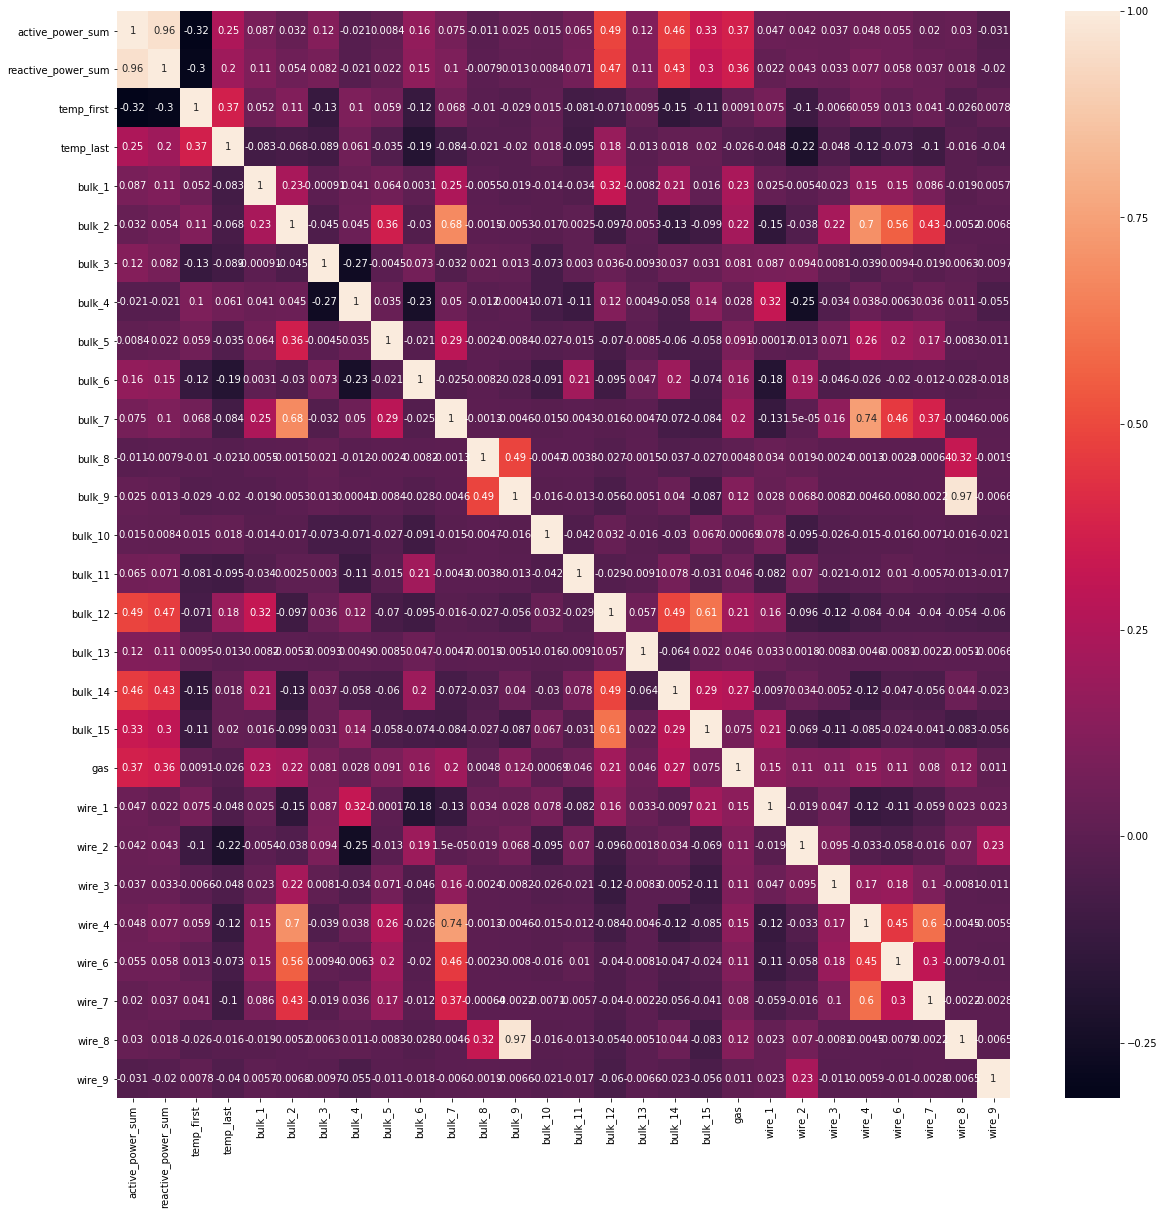

In [61]:
# Посмотрим в матричном виде
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [62]:
#Столбцы active_power_sum и reactive_power_sum, а также bulk_9 и wire_8 очень сильно коррелируют, по сути дублируют друг друга
#Удалим reactive_power_sum и wire_8
data_all = data_all.drop(['reactive_power_sum', 'wire_8'], axis=1)

**Удалим явные выбросы в ключевых столбцах**

In [63]:
# Оценим какие признаки сильнее влияют на конечную температуру
data_all.corr()['temp_last'] 

active_power_sum    0.247650
temp_first          0.366398
temp_last           1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas                -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: temp_last, dtype: float64

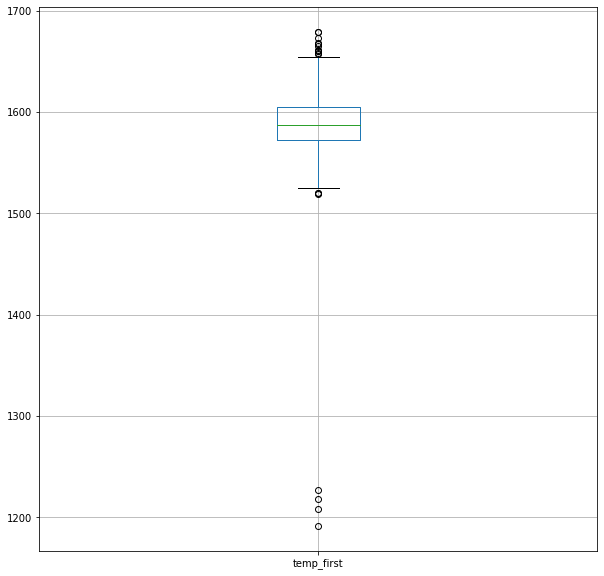

In [64]:
data_all.boxplot(column='temp_first', figsize=(10,10))

In [65]:
data_all = data_all.query('1500 < temp_first')

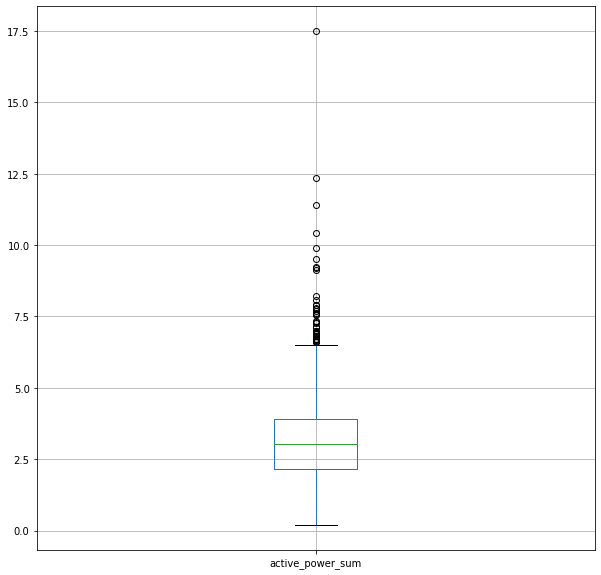

In [66]:
data_all.boxplot(column='active_power_sum', figsize=(10,10))

In [67]:
data_all = data_all.query('active_power_sum < 17')

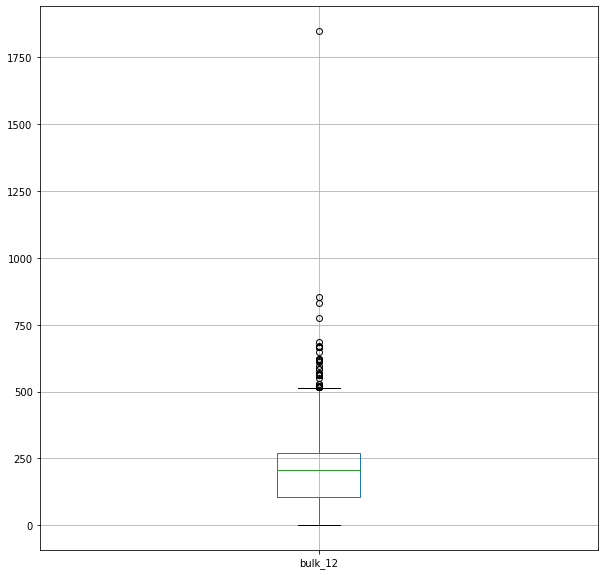

In [68]:
data_all.boxplot(column='bulk_12', figsize=(10,10))

In [69]:
data_all = data_all.query('bulk_12 < 1000')

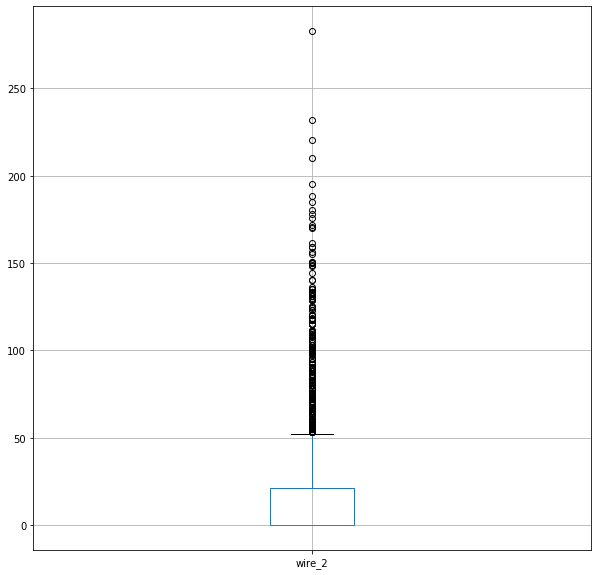

In [70]:
data_all.boxplot(column='wire_2', figsize=(10,10)) 

In [71]:
data_all = data_all.query('wire_2 < 200')

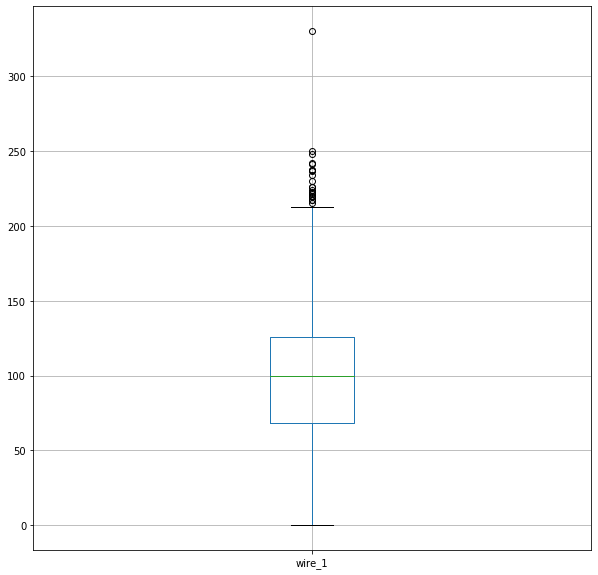

In [72]:
data_all.boxplot(column='wire_1', figsize=(10,10)) 

In [73]:
data_all = data_all.query('wire_1 < 300')

### Вывод

1. Подготовили данные из файла `data_arc` с замерами мощности:
  - Перевели названия столбцов из кириллицы в латиницу.
  - Удалил запись с аномальным значением реактивной мощности -715
  - Изменил типы данных.
  - Создал таблицу с суммарной мощностью потраченную на каждую партию.
  
2. Подготовил данные из файла `data_temp` с замерами температуры:
  - Названия столбцов перевел с кириллицы на латиницу.
  - Изменил типы данных.
  - Удалим данные, в которых последний замер температуры был до окончания последней операции нагрева дугой.
  - Нашел первый и последний замеры температуры для каждой пробы.
  - Добавили столбец с длительностью периода между первым и последним замером температуры.
  - Удалим столбцы с нулевым временем обработки, в них только одно значение temp_count.

3. Объединил данные в одну таблицу по *key* , удалил записи с пропусками.

4. Проверил мультиколлинеарность признаков. Удалил признак *arc_timelagsec_sum*, который сильно коррелирует с признаком *arc_fullpower_sum*, и *wire_8*, коррилирующий с *bulk_9*.


5. Проверили важность признаков. В ключевых признаках удалил аномалии.
    

 # 3 Обучение модели

In [113]:
# Разделим на тренировочную и тестовую выборки

features = data_all.drop('temp_last', axis=1)
target = data_all['temp_last']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)

### LinearRegression

In [114]:
%%time
start_time = time.time()

# Линейная регрессия
model_lr = LinearRegression()
lr_cv_mae = abs(cross_val_score(model_lr, 
                                features_train, 
                                target_train, 
                                scoring='neg_mean_absolute_error',cv=5).mean())

print('Среднее MAE для LinearRegression на train=', np.round(lr_cv_mae,2))
lr_cv_time = time.time() - start_time

Среднее MAE для LinearRegression на train= 7.52
CPU times: user 224 ms, sys: 138 ms, total: 362 ms
Wall time: 284 ms


 ### RandomForestRegressor

In [115]:
%%time
start_time = time.time()
# Подберем параметры
rf_model = RandomForestRegressor(random_state = 12345) 

hyperparametrs = [{'criterion':['mse'],
                  'n_estimators':[x for x in range(100, 500, 50)]}]

grid_rf = GridSearchCV(rf_model, hyperparametrs, cv=5)
grid_rf.fit(features_train, target_train)
print(grid_rf.best_params_)
rf_cv_time_1 = time.time() - start_time

{'criterion': 'mse', 'n_estimators': 250}
CPU times: user 2min 3s, sys: 99.2 ms, total: 2min 3s
Wall time: 2min 4s


In [86]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor(n_estimators=450, random_state = 12345) 
# Значения метрики на кросс валидации

rf_cv_mae = (cross_val_score(rf_model , 
                            features_train, 
                            target_train , 
                            cv=5 , 
                            scoring='neg_mean_absolute_error').mean()*-1)

print('Значение MAE для Random Forest на train:' , rf_cv_mae)

rf_cv_time_2 = time.time() - start_time # Записываем время работы ячейки

Значение MAE для Random Forest на train: 6.052441397594173
CPU times: user 25.8 s, sys: 225 ms, total: 26 s
Wall time: 26.2 s


In [116]:
rf_cv_time = rf_cv_time_1 + rf_cv_time_2

### LGBMRegressor

In [121]:
%%time
start_time = time.time()

LGBM = LGBMRegressor(random_state=12345, learning_rate=0.1) 
hyperparams = [{'num_leaves':[x for x in range(10, 20, 2)] }]

grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_absolute_error', cv=5)
grid_lgbm.fit(features_train, target_train)

print('Лучшие гиперпараметры:')
print()
print(grid_lgbm.best_params_)
print()
print("MAE при разных значениях гиперпараметров:")
print()
means = grid_lgbm.cv_results_['mean_test_score']
stds = grid_lgbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lgbm.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1), params))
print()

lgbm_cv_mae = (max(means)*-1)
lgbm_cv_time = time.time() - start_time # Записываем время работы ячейки

Лучшие гиперпараметры:

{'num_leaves': 10}

MAE при разных значениях гиперпараметров:

6.1243 for {'num_leaves': 10}
6.1787 for {'num_leaves': 12}
6.1894 for {'num_leaves': 14}
6.2132 for {'num_leaves': 16}
6.1880 for {'num_leaves': 18}

CPU times: user 26min 59s, sys: 9.53 s, total: 27min 8s
Wall time: 27min 23s


In [127]:
lgbm_cv_mae = 6.1243

### CatBoostRegressor

In [118]:
%%time
start_time = time.time()

CatBST = CatBoostRegressor(verbose=False, random_state=12345)

catboost_cv_mae = (cross_val_score(CatBST, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Среднее MAE для Catboost на train=', catboost_cv_mae)
catboost_cv_time = time.time() - start_time # Записываем время работы ячейки 

Среднее MAE для Catboost на train= 5.960139405347507
CPU times: user 1min 21s, sys: 14.7 s, total: 1min 36s
Wall time: 1min 43s


# 4 Проверка модели

**LinearRegression**

In [131]:
%%time
start_time = time.time()

model_lr.fit(features_train, target_train)

lr_mae = mean_absolute_error(target_test, model_lr.predict(features_test))

print('Значение MAE для LinearRegression на test =' , lr_mae)

lr_time = time.time() - start_time # Записываем время работы ячейки

Значение MAE для LinearRegression на test = 7.669669251256739
CPU times: user 35.7 ms, sys: 70.4 ms, total: 106 ms
Wall time: 87.3 ms


**RandomForestRegressor**

In [117]:
%%time
# Модель на тестовой выборке
start_time = time.time()

rf_model.fit(features_train, target_train)
rf_mae = mean_absolute_error(target_test, grid_rf.predict(features_test))

print('Значение MAE для Random Forest на test:' , rf_mae)

rf_time = time.time() - start_time # Записываем время работы ячейки 

Значение MAE для Random Forest на test: 6.09453424657534
CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 190 ms


Text(0.5, 0, 'Относительные значения')

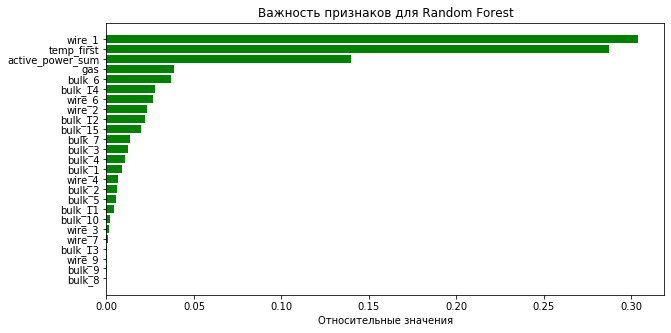

In [95]:
features=features_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

**LGBMRegressor**

In [124]:
%%time
# Модель на тестовой выборке
start_time = time.time()
LGBM_test = LGBMRegressor(random_state=12345, learning_rate=0.1, num_leaves=10)

# Обучаем модель
LGBM_test.fit(features_train, target_train)  
# Делаем предсказания
preds = model.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, preds)

print('Значение MAE для LightGBM на test:', lgbm_mae)

lgbm_time = time.time() - start_time # Записываем время работы ячейки

Значение MAE для LightGBM на test: 4.532512397274021
CPU times: user 40.3 s, sys: 225 ms, total: 40.5 s
Wall time: 40.9 s


Text(0.5, 0, 'Относительные значения')

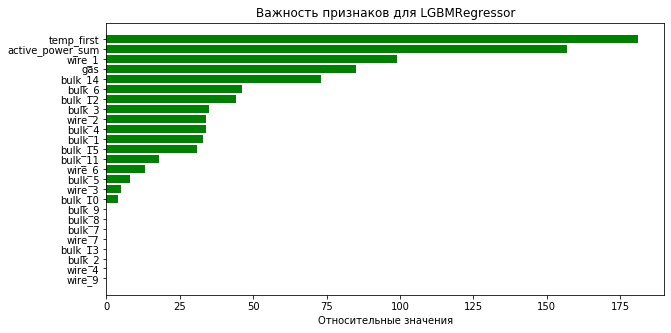

In [125]:
features=features_train.columns
importances = LGBM_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для LGBMRegressor')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

**CatBoostRegressor**

In [119]:
%%time
# Модель на тестовой выборке
start_time = time.time()
CatBST_test = CatBoostRegressor(verbose=False, random_state=12345)

# Обучаем модель
CatBST_test.fit(features_train, target_train)  
# Делаем предсказания
preds = CatBST_test.predict(features_test)
catboost_mae = mean_absolute_error(target_test, preds)

print('Значение MAE для CatBoost на test:', catboost_mae)

catboost_time = time.time() - start_time # Записываем время работы ячейки в переменную

Значение MAE для CatBoost на test: 5.872156139987992
CPU times: user 16.1 s, sys: 3.12 s, total: 19.2 s
Wall time: 20.9 s


Text(0.5, 0, 'Относительные значения')

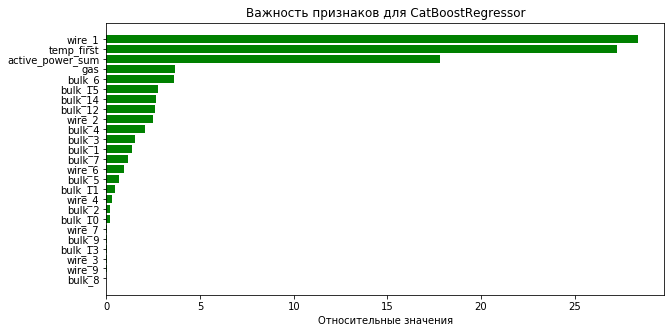

In [96]:
features=features_train.columns
importances = CatBST_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.title('Важность признаков для CatBoostRegressor')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

# Анализ модели

 Для анализа использовали модели: LinearRegression, Random Forest , LightGBM , CatBoost

In [134]:
# Записываем результаты в словарь
dict_results = {'Model': ['LinearRegression,' , 'Random_Forest' , 'LightGBM' , 'CatBoost'],
               'MAE_CV':[lr_cv_mae , rf_cv_mae , lgbm_cv_mae, catboost_cv_mae] ,
               'MAE_test': [lr_mae , rf_mae , lgbm_mae , catboost_mae] , 
               'Working_time_CV' : [lr_cv_time , rf_cv_time , lgbm_cv_time , catboost_cv_time],
               'Working_time_test': [lr_time , rf_time , lgbm_time , catboost_time] ,
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,MAE_CV,MAE_test,Working_time_CV,Working_time_test
0,"LinearRegression,",7.521307,7.669669,0.283874,0.087274
1,Random_Forest,6.052441,6.094534,150.519134,0.189652
2,LightGBM,6.124300,4.532512,1643.302106,40.947929
3,CatBoost,5.960139,5.872156,103.059129,20.922955


Лучшие метрики показали модели CatBoost и LightGBM, при этом CatBoost быстрее обучить.
Интересно, что значение метрики LightGBM в тесте значительно выше, чем на валидации.

In [ ]:
# проверяем адекватность модели

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
predict_dummy = dummy.predict(target_test)
mae_dummy = mean_absolute_error(target_test, predict_dummy)
print('MAE на cлучайной выборке:' ,mae_dummy)

# Отчет

Поставлена задача предсказания температуры стали на производстве.
  - Целевой признак: столбец `temp` в датасете `data_temp`
  - Ключевая метрика:  MAE < 8.7

В ходе выполнения работы :
- Проведена подготовка и анализ данных.
- Названия столбцов перевел с кириллицы на латиницу.
- Изменил типы данных.
- Удалены пропуски и аномалий в данных.
- Создал таблицу с суммарной мощностью потраченную на каждую партию.
- Удалим данные, в которых последний замер температуры был до окончания последней операции нагрева дугой.
- Нашел первый и последний замеры температуры для каждой пробы.
- Удалим столбцы с нулевым временем обработки, в них только одно значение temp_count.
- Созданы и обучены модели.
- Проверена модель на адекватность
- Отчёт

Трудности в ходе выполнения:
- Целевой признак был смешан с остальными. Нужно было выбрать только первую и последнюю температуру.
При этом если время последнего замера было до окончания операций с металлом, то не использовать эти данные для модели.  
- Часть данных имела явные аномалии. Использовал boxplot для ключевых фичей, чтобы не сильно резать датафрейм.
    
Ключевые шаги решения задачи:

- Изучение и анализ данных.
- Генерация фичей.
- Удаление аномалий из данных.
- Выделение целевого признака.
- Объединение данных в единый датасет.
- Подготовка и обучения моделей.

 Лучшую метрику показала модель LightGBM **MAE на тесте = 4.53**. Но при этом эта самая долгая модель. 
   Также хорошо проявила себя модель CatBoost. Она достаточно быстрая, и значения **MAE < 6**, как на тренировочной, так и на тестовой выборках.
